In [1]:
import sys

import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [10]:
class Law:
    """Underlying law which needs to be fitted, the underlying law with be the
    `N_coefficients - 1` Chebyshev polynomial
    """
    def __init__(self, N_law):
        chev_c = np.zeros(N_law); chev_c[-1] = 1
        c_ = np.polynomial.chebyshev.cheb2poly(chev_c)
        self.c = np.asarray(c_)
        
class Data(Law):
    """Set of finite data points, generated from the underlying law"""
    def __init__(self, N_law, N_x, x_i, x_f, noise_level, sigma, N_replicas):
        super().__init__(N_law)
        self.x = (x_f - x_i)*np.random.rand(N_x) + x_i
        self.eta = (noise_level > 0)*sigma*np.random.randn(N_x)
        self.delta = (noise_level > 1)*sigma*np.random.randn(N_replicas, N_x)
        self.y = np.polyval(self.c[::-1], self.x) + self.eta + self.delta
        self.sigma = sigma
        
class Model:
    """Polynomial model to fit the underlying law. Coefficients which correspond to an analytic fit
    of the data are generated upon initialization. Coefficients obtained from a numerical fit are
    generated with the `Numericfit` method
    """
    def __init__(self, N_model, data):
        ho_c = np.zeros(data.c.shape[0])
        ho_c[min([data.c.shape[0], N_model]):] = data.c[min([data.c.shape[0], N_model]):]
        v = np.zeros((data.delta.shape[0], N_model, 1))
        A_inv = np.zeros((data.delta.shape[0], N_model, N_model))
        for i in range(N_model):
            v[:, i] = ((data.eta + data.delta + np.polyval(ho_c[::-1], data.x))*(
                        data.x**(i))).mean(axis=1)[:, np.newaxis]
            for j in range(N_model):
                A_inv[:, i, j] = (data.x**(i+j)).mean()
        A = np.linalg.inv(A_inv)
        c_rep = np.zeros(N_model)
        c_rep[:min([data.c.shape[0], N_model])] = data.c[:min([data.c.shape[0], N_model])]
        self.GA = np.matmul(A, v) + c_rep[np.newaxis,:, np.newaxis]
        self.GN = np.zeros((data.delta.shape[0], N_model))
        self.sigma = data.sigma
    
    def Numericfitext1(self, data, N_steps, lr):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        for i in range(shuffle_index.shape[0]):
            np.random.shuffle(index_range)
            shuffle_index[i, :] = index_range
            y_data[i, :] = data.y[i, index_range]
        x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        #print(gamma.shape)
        gamma_hist = np.random.rand(*self.GN.shape, N_steps)
        #print(gamma_hist.shape)
        grad_chi2 = np.zeros(gamma.shape)
        tv_split = int(x.shape[1]/2)
        chi2_valid = np.zeros((x.shape[0], N_steps))
        for k in range(N_steps):
            y_fit = Generate_y(x[:, :tv_split], gamma)
            for i in range(grad_chi2.shape[1]):
                grad_chi2[:, i] = np.sum((2*(x[:, :tv_split]**(i))*(y_fit - y_data[:, :tv_split])
                                         )/(data.sigma**2), axis=1)
            gamma -= lr*grad_chi2
            gamma_hist[:, :, k] = gamma
            y_valid = Generate_y(x[:, tv_split:], gamma)
            chi2_valid[:, k] = np.sum(((y_valid - y_data[:, tv_split:])**2)/(data.sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
        lookback = np.argmin(chi2_valid, axis=1)
        #print(gamma_hist[np.arange(gamma_hist.shape[0]), :, lookback].shape)
        self.GN = gamma_hist[np.arange(gamma_hist.shape[0]), :, lookback]
    
    def Numericfitext(self, data, N_steps, lr):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        for i in range(shuffle_index.shape[0]):
            np.random.shuffle(index_range)
            shuffle_index[i, :] = index_range
            y_data[i, :] = data.y[i, index_range]
        x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        gamma = Gradientdecent(N_steps, gamma, y_data, x, lr, data.sigma)
        self.GN = gamma
        
    def Numericfit(self, data, N_steps, lr):
        np.random.seed(1234)
        index_range = np.arange(data.x.shape[0])
        shuffle_index = np.zeros(data.y.shape, dtype=int)
        y_data = np.zeros(data.y.shape)
        tv_split = int(y_data.shape[1]/2)
        for i in range(shuffle_index.shape[0]):
            np.random.shuffle(index_range)
            shuffle_index[i, :] = index_range
            y_data[i, :] = data.y[i, index_range]
        x = data.x[shuffle_index]
        #gamma = np.random.rand(*self.GN.shape)*(np.max(self.GA, axis=0)[:,0] - np.min(self.GA, axis=0)[:,0]
        #                                      ) + np.min(self.GA, axis=0)[:,0]
        gamma = np.random.rand(*self.GN.shape)
        gamma_hist, chi2_valid = Gradientdecent2(N_steps,x[:, :tv_split],x[:, tv_split:],y_data[:, :tv_split],
                                                 y_data[:, tv_split:],lr,data.sigma,gamma)
        lookback = np.argmin(chi2_valid, axis=1)
        self.GN = gamma_hist[np.arange(gamma_hist.shape[0], dtype=int), :, lookback]

@jit('f8(f8[:, :], f8[:, :])')
def Generate_y(x, coefficients):
    y = np.zeros((x.shape))
    for i in range(coefficients.shape[1]):
        y += coefficients[:, i, np.newaxis]*(x**i)
    return y
        
def Plotsmoothpoly(coeff):
    """interpolates set of coefficients and plots"""
    x = np.linspace(-1, 1, 100)
    y = np.zeros((x.shape[0], coeff.shape[0]))
    for i in range(coeff.shape[0]):
        y[:, i] = np.polyval(coeff[i, ::-1], x)
    plt.plot(x, y, '-')
    plt.ylim(-2, 2)
    plt.xlim(-1, 1)
    
def Plotdata(x, y):
    """very simple plot of data points"""
    plt.plot(x, y.T, '*')

@jit('f8(i8, f8[:, :], f8[:, :], f8[:, :], f8, f8)')
def Gradientdecent(N_steps, gamma_initial, y_data, x, lr, sigma):
    gamma = gamma_initial
    grad_chi2 = np.zeros(gamma.shape, dtype='f8')
    tv_split = int(y_data.shape[1]/2)
    chi2_valid = np.zeros((y_data.shape[0], N_steps))
    #print(y_data.shape[0])
    gamma_hist = np.zeros((gamma.shape[0], gamma.shape[1], N_steps))
    #print(gamma_hist.shape)
    for k in range(N_steps):
        y_fit = Generate_y(x[:, :tv_split], gamma)
        for i in range(grad_chi2.shape[1]):
            grad_chi2[:, i] = np.sum((2*(x[:, :tv_split]**(i))*(y_fit - y_data[:, :tv_split])
                                        )/(sigma**2), axis=1)
        gamma -= lr*grad_chi2
        gamma_hist[:, :, k] = gamma
        y_valid = Generate_y(x[:, tv_split:], gamma)
        chi2_valid[:, k] = np.sum(((y_valid - y_data[:, tv_split:])**2)/(sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
    lookback = np.argmin(chi2_valid, axis=1)
    return gamma_hist[np.arange(gamma_hist.shape[0], dtype=int), :, lookback]

@jit(nopython=True)
def Gradientdecent2(N_steps,x_train,x_valid,y_train,y_datavalid,lr,sigma,gamma_initial):
    gamma = gamma_initial
    grad_chi2 = np.zeros(gamma.shape)
    chi2_valid = np.zeros((y_datavalid.shape[0], N_steps))
    gamma_hist = np.zeros((gamma.shape[0], gamma.shape[1], N_steps))
    for k in range(N_steps):
        y_fit = np.zeros((x_train.shape))
        for i in range(gamma.shape[1]):
            for j in range(gamma.shape[0]):
                y_fit[j, :] += gamma[j, i]*(x_train[j, :]**i)
        for i in range(grad_chi2.shape[1]):
            grad_chi2[:, i] = np.sum((2*(x_train**(i))*(y_fit - y_train)
                                        )/(sigma**2), axis=1)
        gamma -= lr*grad_chi2
        gamma_hist[:, :, k] = gamma
        y_valid = np.zeros((x_train.shape))
        for i in range(gamma.shape[1]):
            for j in range(gamma.shape[0]):
                y_valid[j, :] += gamma[j, i]*(x_valid[j, :]**i)
        chi2_valid[:, k] = np.sum(((y_valid - y_datavalid)**2)/(sigma**2), axis=1)
            #if k % 100 == 0: sys.stdout.write('\rStep {0}'.format(k))
    return gamma_hist, chi2_valid
        

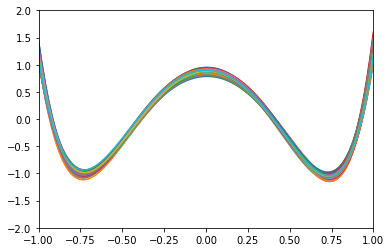

In [11]:
data_1 = Data(N_law=5, N_x=200, x_i=-1, x_f=1, noise_level=2, sigma=0.1, N_replicas=100)
model_1 = Model(N_model=8, data=data_1)
model_1.Numericfit(data_1, 10000, 0.00001)
Plotsmoothpoly(model_1.GN)

In [4]:
#top funciton with jit
#%timeit model_1.Numericfit(data_1, 10000, 0.00001)
#print(model_1.GN[0])
#%timeit model_1.Numericfitext(data_1, 10000, 0.00001)
#print(model_1.GN[0])
#%timeit model_1.Numericfitext1(data_1, 10000, 0.00001)

14.6 s ± 553 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.9 s ± 3.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.1 s ± 891 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


output of above cell (don't recommend running again):

14.6 s ± 553 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

47.9 s ± 3.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

46.1 s ± 891 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Now faster with jit, since the compiler can make sense of all of the types

In [6]:
a = np.arange(15)
b = a.reshape((3, 5))
b[:, [2]]

array([[ 2],
       [ 7],
       [12]])